In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import json

import numpy as np
import pandas as pd
import geopandas as gpd

from shapely import geometry
from geopy.distance import vincenty

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import linear_model
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

plt.rcParams['figure.figsize']=(14,6)

### Загруза данных

In [2]:
#realt = pd.read_json('../parsing/realt_2212_12-30.json')
#realt = pd.read_csv('../data/realt.csv')
realt = pd.read_json('../parsing/realt_2712_13-30.json')
print("Количество квартир: {}".format(realt.shape[0]))
realt.head(3)

Количество квартир: 2101


,address,area,code,description,floor,kv,latitude,longitude,photos,price_local,price_usa,views_day,views_week,zones,Агентство,Балкон,Бытовая техника,Вид этажа,Год кап.ремонта,Год постройки,Дата обновления,Дополнительно,Мебель,Метро,На Новый год,Направление,Населенный пункт,Планировка,Плита,Полы,Предоплата,Примечания,Район (области),Район города,Ремонт,Сан/узел,Соседи по квартире,Специалист,Срок сдачи,Телефон,Тип дома,УНП,Условия сдачи,Услуга агентства,Число спальных мест,Этаж / этажность
0,"Гатово, Металлургическая ул., 22",34/17/9,1210700,,6/9 б,1/1,53.783539,27.627417,4.0,237 руб/месяц,120 $/месяц,7,149,NaN,NaN,балкон,"холодильник, свч-печь, стиральная машина, теле...",NaN,NaN,1991.0,2017-12-11,"металлическая дверь, лифт, встроенные шкафы, с...",есть,NaN,NaN,Пуховичское,Гатово,улучшенный проект,газовая,ламинат,3 месяца,Сдаётся однокомнатная квартира с хорошим ремон...,NaN,NaN,отличный ремонт,раздельный,NaN,NaN,длительный,есть,блок-комнаты,NaN,не компаниям,NaN,NaN,6 / 9
1,"Минск, Сухаревская ул.",76/18/12,1212276,,8/9 кар,к/3,53.888064,27.428422,8.0,297 руб/месяц,150 $/месяц,7,50,Сухарево,NaN,лоджия застекленная,"холодильник, посуда, свч-печь, мелкая бытовая ...",NaN,NaN,2009.0,2017-12-14,"домофон, металлическая дверь, лифт, стеклопаке...",есть,NaN,NaN,NaN,Минск,новостройка,электрическая,ламинат,месяц,Сдаю в аренду большую комнату в благоустроенно...,NaN,Фрунзенский район,хороший ремонт,2 сан/узла,1 человек,NaN,длительный,есть,каркасно-блочный,NaN,семье,NaN,NaN,8 / 9
2,"Минск, Куйбышева ул., 48",61/12/6,1213112,,4/5 к,к/3,53.925400,27.582700,9.0,237 руб/месяц,120 $/месяц,4,33,"Богдановича, Куйбышева, Веры Хоружей",NaN,лоджия,NaN,NaN,NaN,1969.0,2017-12-15,"домофон, металлическая дверь, окна во двор, де...",частично,Площадь Якуба Коласа (Московская линия).,NaN,NaN,Минск,улучшенный проект,газовая,паркет,NaN,Сдам на длительный срок (не агентство) комнату...,NaN,Советский район,нормальный ремонт,раздельный,NaN,NaN,длительный,есть,кирпичный,NaN,NaN,NaN,NaN,4 / 5


## Обработка датасета (часть 1)

### Цена

In [3]:
def get_realt_price(price):
    """
    Убирает дробную часть в цене
    """
    return int(''.join(re.findall(r'\d+', re.sub(r'[,.]\d+', ' ', price))))

# Удаление записи без цены
realt.drop(realt[realt['price_usa'] == 'Цена договорная'].index, inplace=True)

# Исправление цены
realt['price_usa'] = realt['price_usa'].apply(get_realt_price)
realt['price_local'] = realt['price_local'].apply(get_realt_price)

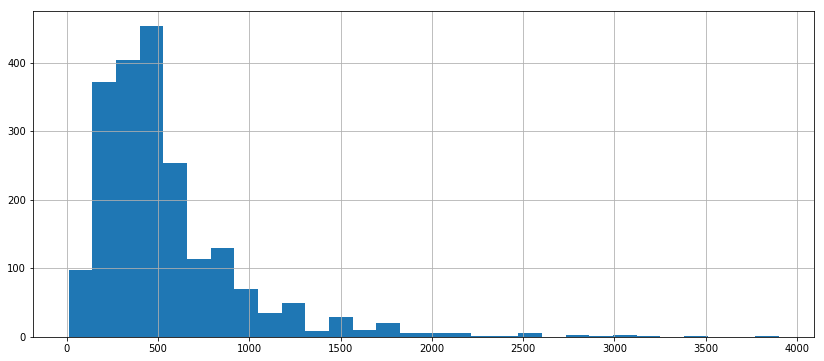

In [4]:
realt['price_usa'].hist(bins=30)

### Только Минск

Количество квартир только по Минску: 1982


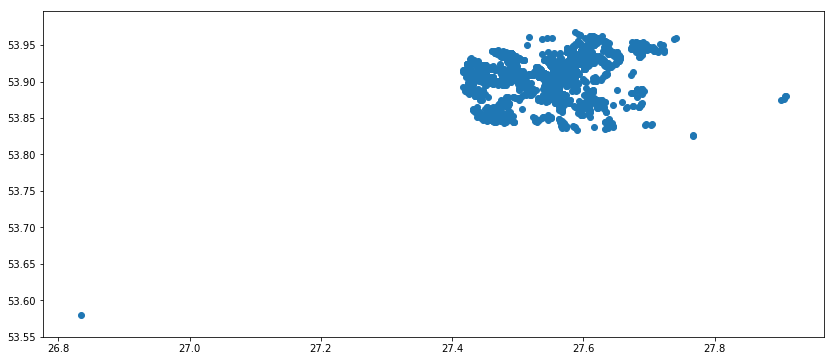

In [5]:
# Только Минск
realt = realt[realt['Населенный пункт'] == 'Минск']
plt.scatter(realt['longitude'], realt['latitude'])

realt.drop(realt[(realt['longitude'] > 27.8) | (realt['longitude'] < 27.3)].index, inplace=True)
print("Количество квартир только по Минску: {}".format(realt.shape[0]))

### Убираем колонки с большим количеством пропусков

In [6]:
drop_realt = ['УНП',
             'Район (области)',
             'Специалист',
             'Число спальных мест',
             'Направление',
             'На Новый год',
             'Вид этажа',
             'Год кап.ремонта', #много пропусков
             'Услуга агентства',
             'Срок сдачи', #?
             'Условия сдачи', #?
             'Населенный пункт',
             'Предоплата'
             ]
realt.drop(drop_realt, axis=1, inplace=True)

### Вот что осталось

In [7]:
realt.isnull().sum(axis=0)

address                  0
area                     0
code                     0
description              0
floor                    0
kv                       0
latitude                 0
longitude                0
photos                 163
price_local              0
price_usa                0
views_day                0
views_week               0
zones                    0
Агентство             1228
Балкон                 816
Бытовая техника        770
Год постройки          449
Дата обновления          0
Дополнительно          827
Мебель                 197
Метро                  463
Планировка             366
Плита                  967
Полы                   414
Примечания            1063
Район города             0
Ремонт                 253
Сан/узел               728
Соседи по квартире    1928
Телефон                381
Тип дома               335
Этаж / этажность         8
dtype: int64

### Заполнение пропусков

In [8]:
realt['description'].fillna('', inplace=True)
realt['Дополнительно'].fillna('', inplace=True)
realt['Примечания'].fillna('', inplace=True)
realt['photos'].fillna(0, inplace=True)
realt['Агентство'].fillna("нет", inplace=True)
realt['Балкон'].fillna("нет", inplace=True)
realt['Бытовая техника'].fillna('', inplace=True)
realt['Телефон'].fillna('нет', inplace=True)
realt['Мебель'].fillna('нет', inplace=True)
realt['Метро'].fillna('нет', inplace=True)
realt['Плита'].fillna('Пропуск', inplace=True)
realt['Ремонт'].fillna('Пропуск', inplace=True)
realt['Этаж / этажность'].fillna('0 / 0', inplace=True)
realt['Соседи по квартире'].fillna('нет', inplace=True)

#### Соседи по квартире

In [9]:
realt.drop(realt[realt['Соседи по квартире'] != 'нет'].index, inplace=True)

#### Количество комнат

In [10]:
# кол-во комнат (0 - комната)
realt['rooms'] = realt['kv'].apply(lambda kv: 0 if kv.split('/')[0]==' к' else int(kv.split('/')[0]))

#### Площадь

In [11]:
# площадь 
realt['total_area'] = realt['area'].apply(lambda area: int(''.join(re.findall(r'\w+', area.split('/')[0]))))
realt['living_area'] = realt['area'].apply(lambda area: int(area.split('/')[1]))
realt['kitchen_area'] = realt['area'].apply(lambda area: int(area.split('/')[2])) # 0 - это пропуск

# Замена нулей в общей площади на медианную площадь для квартир с таким же кол-вом комнат
for area in ['total_area', 'living_area', 'kitchen_area']:
    realt.loc[realt[(realt[area]==0)].index, area] = realt[(realt[area]==0)].merge(
        realt.groupby(by='rooms').agg(
            [np.mean, np.min, np.max, np.median]
        )[area].reset_index(),
        on='rooms'
    )['median']

# Убираем обьявления по комнатам и коттеджам
realt = realt[(realt['total_area']<=300) &(realt['rooms']!=0)]
print("Количество квартир сдаваемых в Минске: {}".format(realt.shape[0]))

Количество квартир сдаваемых в Минске: 1899


#### Балкон

In [12]:
def get_numb_balcony(text):
    if text == 'нет':
        return 0
    elif text.split()[0] in ['лоджия', 'балкон']:
        return 1
    else:
        return 2
realt['Балкон'] = realt['Балкон'].apply(get_numb_balcony)

#### Мебель

In [13]:
# мебель (частично -> нет)
realt['Мебель'].replace('частично', 'нет', inplace=True)
realt['Мебель'] = realt['Мебель'].apply(lambda furniture: 0 if furniture == 'нет' else 1)

#### Телефон

In [14]:
# телефон
realt['Телефон'].replace({'нет': 0,
                          'есть': 1,
                          '2 телефона': 2}, inplace=True)

#### Плита

In [15]:
# Плита: Пропуск -> электрическая
realt['Плита'].replace('Пропуск', 'электрическая', inplace=True)
realt['Плита'] = realt['Плита'].apply(lambda plate: 0 if plate == 'газовая' else 1)

#### Ремонт

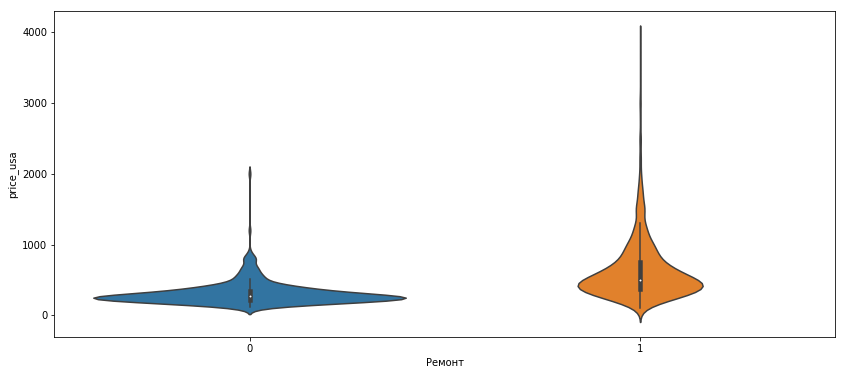

In [16]:
# Ремонт:  хороший ремонт (1) и без ремонта (0). 
realt['Ремонт']=realt['Ремонт'].replace({'Пропуск': 1,
                         'отличный ремонт': 1,
                         'евроремонт': 1,
                         'без отделки': 0,
                         'строительная отделка': 0,
                         'удовлетворительный ремонт': 0,
                         'нормальный ремонт': 0,
                         'без отделки': 0,
                         'плохое состояние': 0,
                         'хороший ремонт': 0})
sns.violinplot('Ремонт', 'price_usa', data=realt)

#### Этаж / этажность

In [17]:
def get_floor_features(text):
    """
    Возвращает (этаж, этажность)
    0 - пропуск (как вариант, пропуск этажности можно заменить на этаж)
    """
    items = re.findall(r'\w+', text)
    if items[-1] in {'этажей', 'этажа'}:
        return (0, int(items[0]))
    elif items[-1] == 'этаж':
        return (int(items[0]), 0)
    else:
        return (int(items[0]), int(items[1]))
    
# Этаж / этажность
realt['floor'] = realt['Этаж / этажность'].apply(lambda f: get_floor_features(f)[0])
realt['floors'] = realt['Этаж / этажность'].apply(lambda f: get_floor_features(f)[1])

# Замена пропуска в этажности на этаж
realt['floors'].replace(0, realt['floor'], inplace=True)

#### Агентство

In [18]:
# Агентство
realt['Агентство'] = realt['Агентство'].apply(lambda agent: 0 if agent=='нет' else 1)

#### Планировка

In [19]:
realt['Планировка'].unique()

array([nan, 'новостройка', 'брежневка', 'хрущевка', 'улучшенный проект',
       'стандартный проект', 'сталинка', 'малосемейка', 'чешский проект',
       'бреж', 'чеш.', 'пентхаус', 'стал', 'таунхаус'], dtype=object)

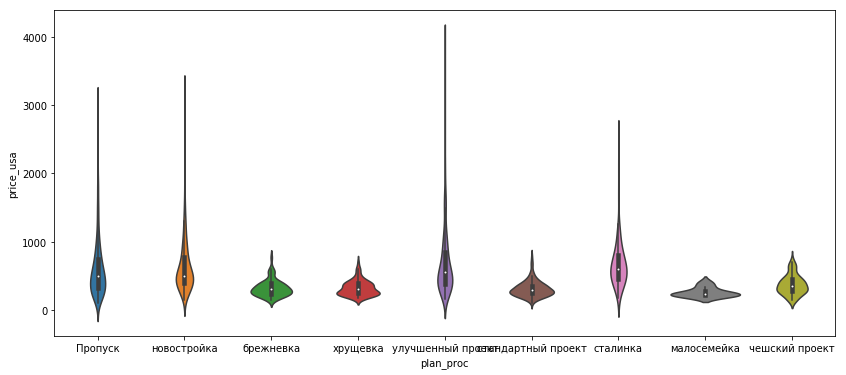

In [20]:
realt['Планировка'].fillna('Пропуск', inplace=True)
realt['plan_proc'] = realt['Планировка'].replace({'бреж': 'брежневка',
                             'стал': 'сталинка',
                             'чеш.': 'чешский проект',
                             'таунхаус': 'Пропуск',
                            'пентхаус': 'Пропуск',
                            })
sns.violinplot('plan_proc', 'price_usa', data=realt)

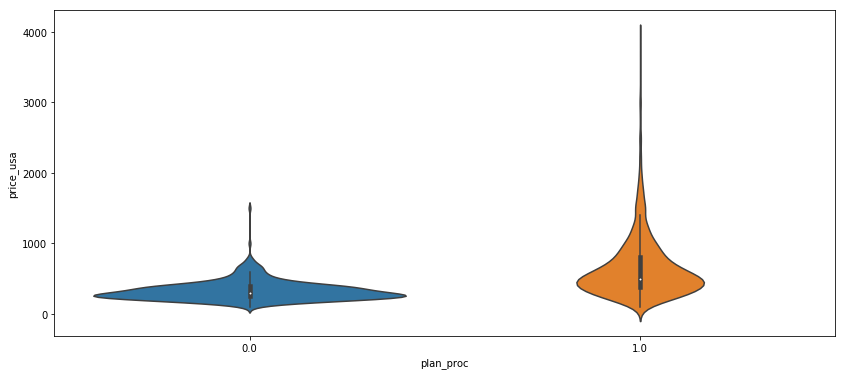

In [21]:
# 0 - так себе
# 1 - норм
plan_union = {'брежневка':0,
              'стандартный проект':0,
              'хрущевка':0,
              'малосемейка': 0,
              'чешский проект':0,
              'сталинка':1,
              'новостройка': 1,
              'улучшенный проект':1,
              'Пропуск':1,
              }
realt['plan_proc']=realt['Планировка'].map(plan_union)
realt['plan_proc'].fillna(0, inplace=True)
sns.violinplot('plan_proc', 'price_usa', data=realt)

#### Тип дома

In [22]:
realt['Тип дома'].unique()

array([nan, 'панельный', 'кирпичный', 'монолитный', 'каркасно-блочный',
       'кб', 'монолитно-каркасный', 'блок-комнаты', 'сб', 'КБ', 'бр'], dtype=object)

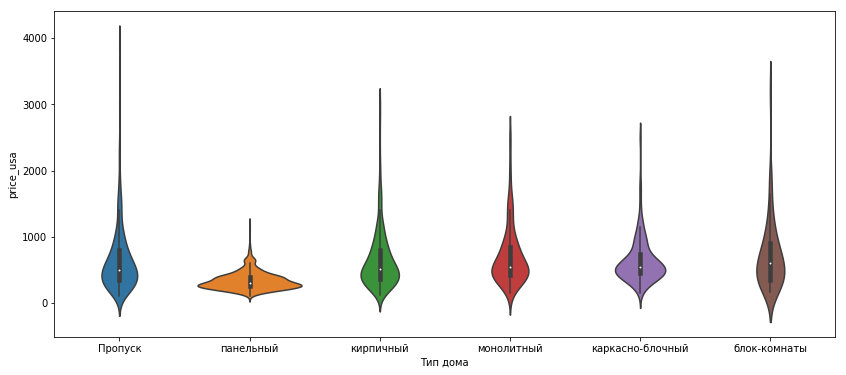

In [23]:
realt['Тип дома'].fillna('Пропуск', inplace=True)
realt['Тип дома'].replace({'кб': 'каркасно-блочный',
                           'КБ': 'каркасно-блочный',
                           'сб': 'Пропуск',
                           'бр': 'Пропуск',
                           'монолитно-каркасный': 'монолитный'
                            }, inplace=True)

sns.violinplot('Тип дома', 'price_usa', data=realt)

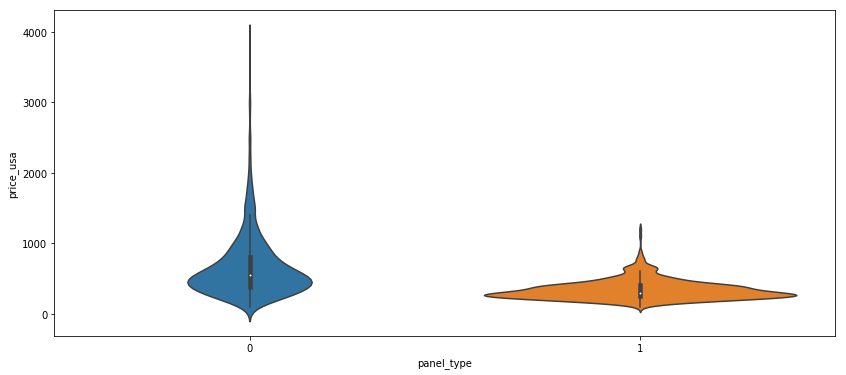

In [24]:
# панельный / не панельный
realt['panel_type'] = realt['Тип дома'].apply(lambda t: 1 if t == 'панельный' else 0)
sns.violinplot('panel_type', 'price_usa', data=realt)

#### Год постройки

In [25]:
# Если по этому же адресу есть еще обьявление с указанием года постройки, то он проставится и этому обьявлению
house_year = realt[~pd.isnull(realt['Год постройки'])][['address', 'Год постройки']].groupby(by='address').mean().reset_index()
house_year.set_index('address', inplace=True)
realt.set_index('address', inplace=True)
realt['Год постройки'] = realt['Год постройки'].fillna(value=house_year['Год постройки'])
realt.reset_index(inplace=True)

#Нужно доработать
realt['Год постройки'] = realt['Год постройки'].fillna(value= realt['Планировка'].apply(
                                                                     lambda x:realt[realt['Планировка']==x].groupby(
                                                                         by='Планировка')['Год постройки'].median().values[0] ))

#### Сан/узел

In [26]:
realt['Сан/узел'].fillna(1, inplace=True)
realt['Сан/узел'].replace({'раздельный': 1,
                           'совмещенный': 1,
                           '2 сан/узла': 2,
                           '3 сан/узла': 3
                            }, inplace=True)

#### Photos

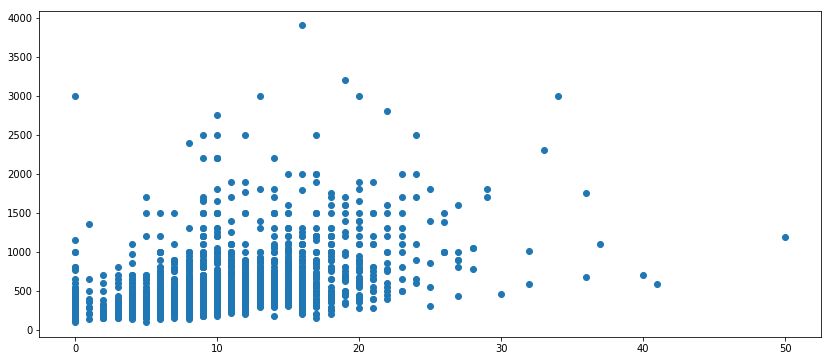

In [27]:
plt.scatter(realt['photos'], realt['price_usa'])

In [28]:
realt['photos_proc'] = realt['photos'].clip(0, 25)

#### Линия метро

### Бытовая техника из описания

In [29]:
# Какая техника вообще есть
tech_set = set()
for descr in realt['Бытовая техника']:
    tech_set.update(descr.split(', '))
print(list(tech_set))

['', 'свч-печь', 'холодильник', 'видеомагнитофон', 'душевая кабина', 'DVD-проигрыватель', 'домашний кинотеатр', 'посудомоечная машина', 'стиральная машина', 'компьютерная сеть', 'музыкальный центр', 'высокоскоростной интернет', 'компьютер', 'джакузи', 'посуда', 'выделенная линия в интернет', 'интернет', 'кондиционер', 'мелкая бытовая техника', 'телевизор']


In [30]:
def get_tech_from_descr(text):
    """
    Извлекает бытовую технику из описания
    (мб можно проще)
    """
    result = []
    text = text.lower()
    if 'душевая' in text:
        result.append('душевая кабина')
    if 'интернет' in text:
        result.append('интернет')
    if 'музыкальный центр' in text:
        result.append('музыкальный центр')
    if 'dvd' in text:
        result.append('DVD-проигрыватель')
    if 'кондиционер' in text:
        result.append('кондиционер')
    if 'посудомоечная' in text: 
        result.append('посудомоечная машина')
    if 'джакузи' in text:
        result.append('джакузи')
    if any(tv in text for tv in ['телевизор', 'тв', 'телик']):
        result.append('телевизор')
    if 'свч' in text:
        result.append('свч-печь')
    if 'холодильник' in text:
        result.append('холодильник')
    if 'компьютер' in text:
        result.append('компьютер')
    if 'видеомагнитофон' in text:
        result.append('видеомагнитофон')
    if 'домашний кинотеатр' in text:
        result.append('домашний кинотеатр')
    if 'стиральная' in text:
        result.append('стиральная машина')
    return ', '.join(result)

In [31]:
# Кол-во пропусков для записей с описанием (description)
print("Кол-во пропусков до замены: {}".format(realt[(realt.description != '') & (realt['Бытовая техника'] == '')].shape[0]))
realt.loc[(realt.description != '') & (realt['Бытовая техника'] == ''), 'Бытовая техника'] = realt.loc[(realt.description != '') & (realt['Бытовая техника'] == ''), 'description'].apply(get_tech_from_descr)
print("Кол-во пропусков после замены: {}".format(realt[(realt.description != '') & (realt['Бытовая техника'] == '')].shape[0]))

Кол-во пропусков до замены: 577
Кол-во пропусков после замены: 148


### "Дополнительно" из описания

In [32]:
# Какое "дополнительно" вообще есть
dop_set = set()
for descr in realt['Дополнительно']:
    dop_set.update(descr.split(', '))
print(dop_set)

{'', 'гараж', 'видео-домофон', 'рядом магазин', 'элитная квартира', 'домофон', 'лифт', 'благоустроенный двор', 'парковка', 'сигнализация', 'окна во двор', 'встроенные шкафы', 'стеклопакеты', 'хороший вид из окна', 'VIP-квартира', 'видеодомофон', 'рядом рынок', 'рядом зеленая зона отдыха', 'рядом зеленая зона', 'охраняемая территория', 'рядом спортивный центр', 'консьержка', 'подземный гараж', 'металлическая дверь', 'встроеные шкафы', 'рядом гипермаркет', 'рядом супермаркет', 'детская площадка'}


In [33]:
def get_dop_from_descr(text):
    """
    Извлекает "дополнительно" из описания
    (мб можно проще)
    """
    result = []
    text = text.lower()
    if any(door in text for door in ['металлическая дверь', 'металическая дверь']):
        result.append('металлическая дверь')
    if 'рядом зеленая зона' in text:
        result.append('рядом зеленая зона')
    if any(vid_dom in text for vid_dom in ['видеодомофон', 'видео-домофон']):
        result.append('видеодомофон')
    if any(yard in text for yard in ['благоустроенный двор', 'благоустроеный двор']):
        result.append('благоустроенный двор')
    if 'лифт' in text:
        result.append('лифт')
    if any(garage in text for garage in ['гараж', 'подземный гараж']):
        result.append('гараж')
    if 'парковка' in text:
        result.append('парковка')
    if 'магазин' in text:
        result.append('рядом магазин')
    if 'детская площадка' in text:
        result.append('детская площадка')
    if 'спортивный центр' in text:
        result.append('рядом спортивный центр')
    if any(guard_zone in text for guard_zone in ['охраняемая территория', 'охраняемая територия']):
        result.append('охраняемая территория')
    if 'сигнализация' in text:
        result.append('сигнализация')
    if 'гипермаркет' in text:
        result.append('рядом гипермаркет')
    if 'стеклопакеты' in text:
        result.append('стеклопакеты')
    if any(wardrobe in text for wardrobe in ['встроенные шкафы', 'встроеные шкафы']):
        result.append('встроенные шкафы')
    if 'хороший вид из окна' in text:
        result.append('хороший вид из окна')
    if 'консьержка' in text:
        result.append('консьержка')
    if 'супермаркет' in text:
        result.append('рядом супермаркет')
    if 'домофон' in text:
        result.append('домофон')
    if 'рынок' in text:
        result.append('рядом рынок')
    if 'супермаркет' in text:
        result.append('рядом супермаркет')
    if any(wardrobe in text for wardrobe in ['элитная квартира', 'vip']):
        result.append('VIP-квартира')
    return ', '.join(result)

In [34]:
# Кол-во пропусков для записей с описанием (description)
print("Кол-во пропусков до замены: {}".format(realt[(realt.description != '') & (realt['Дополнительно'] == '')].shape[0]))
realt.loc[(realt.description != '') & (realt['Дополнительно'] == ''), 'Дополнительно'] = realt.loc[(realt.description != '') & (realt['Дополнительно'] == ''), 'description'].apply(get_dop_from_descr)
print("Кол-во пропусков до замены: {}".format(realt[(realt.description != '') & (realt['Дополнительно'] == '')].shape[0]))

Кол-во пропусков до замены: 579
Кол-во пропусков до замены: 276


### Извлечение микрорайонов

In [35]:

realt.drop(['area',
            'Этаж / этажность',
            'kv'], axis=1, inplace=True)

realt['living_area'].fillna(realt['living_area'].median(), inplace=True)
realt['kitchen_area'].fillna(realt['kitchen_area'].median(), inplace=True)

### Метро (ближайшее и расстояние)

In [36]:
metro = gpd.read_file('../data/minsk_belarus.imposm-geojson/minsk_belarus_transport_points.geojson')

In [37]:
# чтобы проще было метро доставать
metro.loc[metro['name'] == 'Трактарны завод', 'ref'] = 213
metro.loc[metro['name'] == 'Аўтазаводская', 'ref'] = 211
metro.loc[metro['name'] == 'Няміга', 'ref'] = 217
metro.loc[metro['name'] == 'Першамайская', 'ref'] = 215
metro.loc[metro['name'] == 'Пралетарская', 'ref'] = 214
metro.loc[metro['name'] == 'Спартыўная', 'ref'] = 221
metro.loc[metro['name'] == 'Магілёўская', 'ref'] = 210
metro.loc[metro['name'] == 'Пушкінская', 'ref'] = 220
metro.loc[metro['name'] == 'Партызанская', 'ref'] = 212
metro.loc[metro['name'] == 'Маладзёжная', 'ref'] = 219
metro.loc[metro['name'] == 'Купалаўская', 'ref'] = 216
metro.loc[metro['name'] == 'Фрунзенская', 'ref'] = 218

In [38]:
metro = metro[(metro['type'] == 'station') & (metro['ref'] != '')] # только метро
for i in tqdm_notebook(realt.index):
    first_point = realt.loc[i, ['latitude', 'longitude']]
    min_dist = metro['geometry'].apply(lambda coord: vincenty(first_point, (coord.y, coord.x)).m).agg(('argmin', 'min'))
    realt.at[i, 'Ближайшее метро'] = metro.loc[min_dist['argmin'], 'name']
    realt.at[i, 'До метро'] = min_dist['min']

HBox(children=(IntProgress(value=0, max=1899), HTML(value='')))

### До центра

In [39]:
center = (53.902496, 27.561481) # Октябрьская площадь
for i in realt.index:
    first_point = realt.loc[i, ['latitude', 'longitude']]
    realt.at[i, 'До центра'] = vincenty(first_point, (center[0], center[1])).m

### Сохранение

In [40]:
realt.to_csv('../data/realt_2712_13-30.csv', index=False)
#realt.to_csv('../data/realt_lite_final.csv', index=False)